# Project 2 - Using Feed-Forward Neural Networks for linear and logistic regression

## Main program
### Program imports

In [18]:
from networkClasses import *
from classSupport import *
from methodSupport import *

import autograd.numpy as anp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### Program defaults

In [19]:
## Random seed
def_seed = 1
np.random.seed(def_seed); anp.random.seed(def_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (8,3); plt.rcParams["font.size"] = 10


### **Part a)** Stochastic Gradient Descent for polynomial approximation
#### Dataset setup

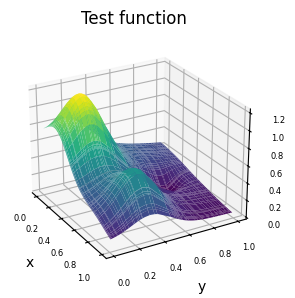

In [20]:
cases = ['1D','2D','Franke']
case_ = cases[2]
show = False

# Grid and data setup
a      = [1.0, 1.5, 1.2]                                   # Coefficients for exponential model
c0, c1 = 0.2, 0.95                                         # Noise scaling    
x0, xN = 0, 1                                              # Start and end of domain, x-axis
y0, yN = 0, 1                                              # Start and end of domain, y-axis
Nx, Ny = 100, 100                                          # Number of sample points
'''
x   = np.sort(np.random.uniform(x0,xN,Nx)).reshape(-1,1)    # Mesh points on x-axis (uniformly distributed, sorted values)
y   = np.sort(np.random.uniform(y0,yN,Ny)).reshape(-1,1)    # Mesh points on y-axis (uniformly distributed, sorted values) (try different length arrays in x and y if singular values are an issue)
x_n = np.random.normal(0, c0, x.shape)                      # Noise for x-axis
y_n = np.random.normal(0, c0, y.shape)                      # Noise for y-axis

if case_ == '1d':
    z = test_func(x,a)
    if show == True:
        fig,ax = plt.subplots(1,1)
        ax.plot(x,z)
        ax.set_title('Test function')
elif case_ == '2d':
    xx,yy = anp.meshgrid(x,y)
    z = exp2D(x,y,a)
    if show == True:
        fig,ax = plt.subplots(1,1)
        ax.plot([0,1],[2,3])
        ax.set_title('Test function')
elif case_ == 'Franke':
    xx,yy = anp.meshgrid(x,y)
    z = Franke(x,y)
    if show == True:
        fig,ax = plt.subplots(1,1)
        ax.plot([0,1],[2,3])
        ax.set_title('Test function')

#'''

dataset = Initializer(problem_case=case_,sample_size=[Nx,Ny])
dataset.domain_setup(noise=c0)
dataset.test_function(a)
f = dataset.plot(labels=['Test function','x','y','dataset','true'])

#### Gradient Descent Analysis
##### Plain GD and GD with momentum

Method: PlainGD
MSE, SGD
0.008536663853832144
MSE, Lin.Reg
0.002118027547602862 

Method: MomentumGD
MSE, SGD
0.010119152777322267
MSE, Lin.Reg
0.002118027547602862 



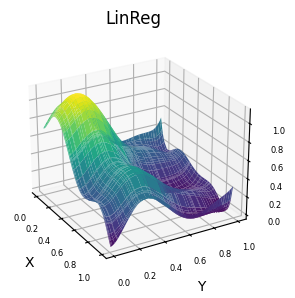

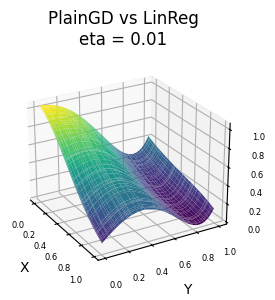

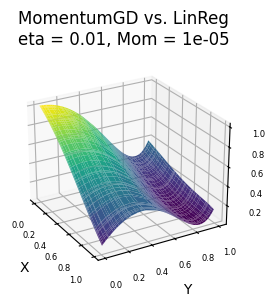

In [21]:
## Regression setup and initialization
eta = 0.01; n_iter = 10; lmbda = 0.0001

lin_gd = LinearRegressor(learning_rate=eta,num_iterations=n_iter)

## Design matrix
poly_deg = 7
if case_ == '1D':
    target = dataset.target[0]
    x = dataset.x
    X = lin_gd.design_matrix(x=x,poly_deg=poly_deg,intercept=True)
else:
    target = dataset.target_f#; target_f = dataset.target_f
    x = dataset.xf; y = dataset.yf
    X = lin_gd.design_matrix(x=[x,y],poly_deg=poly_deg,intercept=True)


## Stochastic GD - parameters
batch_size = Nx // 2
batches = int(X.shape[0]/batch_size)
epochs = 1000

if epochs > n_iter:
    n_iter = epochs

## Scaling
X_s = X#lin_gd.scale(X)
target_s = target#lin_gd.scale(target)

mom = [0., 0.00001]
GDMethod = [PlainGD(eta),MomentumGD(eta,momentum=mom[1])]

GradMethod = LassoGrad(lmbda)
#GradMethod = AutoGrad(lmbda,mse_lasso)

## GD-fitting and linear prediction
lin_gd.linear_predict(X,target,predict_type='Ridge',lmbda=lmbda)
prediction_reg = X @ lin_gd.beta_linreg# + lin_gd.intcept
if case_ != '1D':
    pred_reg = prediction_reg.reshape(Nx,Ny)
    lin_gd.plot([dataset.xx,dataset.yy],pred_reg,labels=['LinReg','X','Y','data','SGD','LinReg'])

title_list= ['PlainGD vs LinReg\neta = %g' %(eta),'MomentumGD vs. LinReg\neta = %g, Mom = %g' %(eta,mom[1])]

for i,method in enumerate(GDMethod):

    lin_gd.reg_fit(X_s,target_s,method,GradMethod,batches=batches,epoch=epochs)

    prediction_gd = X @ lin_gd.beta_gd# + lin_gd.gd_intcept

    print(f'Method: {method.__class__.__name__}')
    if show == True:
        print('β_gd')
        print(lin_gd.beta_gd)
        print('β_lin')
        print(lin_gd.beta_linreg)
        
    print('MSE, SGD')
    print(lin_gd.predict(lin_gd.beta_gd,X,target))
    print('MSE, Lin.Reg')
    print(lin_gd.predict(lin_gd.beta_linreg,X,target),'\n')

    if case_ == '1D':
        lin_gd.plot(x,[target,prediction_gd,prediction_reg],labels=[title_list[i],'X','Y','data','SGD','LinReg'])
    else:
        pred_gd = prediction_gd.reshape(Nx,Ny)
        lin_gd.plot([dataset.xx,dataset.yy],pred_gd,labels=[title_list[i],'X','Y','data','SGD','LinReg'])

    lin_gd.reset()

plt.show()

##### Adagrad, RMSprop and ADAM

Method: Adagrad
MSE, SGD
0.10424909962058677
MSE, Lin.Reg
0.002118027547602862 

Method: RMSprop
MSE, SGD
0.03985460295779641
MSE, Lin.Reg
0.002118027547602862 

Method: ADAM
MSE, SGD
0.006380521703177277
MSE, Lin.Reg
0.002118027547602862 



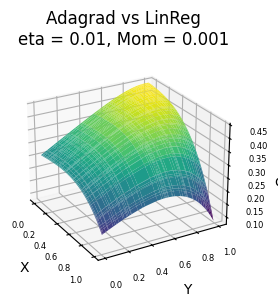

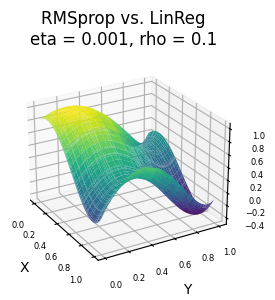

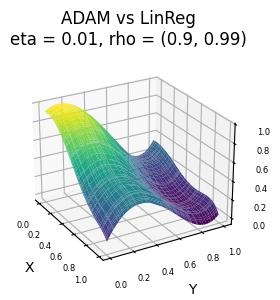

In [22]:
eta_ada, adagrad_mom = 0.01,0.001
eta_rms,rms_decay = 0.001,0.1
eta_ADAM, ADAM_decay = 0.01,[0.9, 0.99]

GDMethod = [Adagrad(eta_ada,momentum=adagrad_mom),RMSprop(eta,decay=rms_decay),ADAM(eta,decay_rate_1=ADAM_decay[0],decay_rate_2=ADAM_decay[1])]

title_list = ['Adagrad vs LinReg\neta = %g, Mom = %g'%(eta_ada,adagrad_mom),
              'RMSprop vs. LinReg\neta = %g, rho = %g' %(eta_rms,rms_decay),
              'ADAM vs LinReg\neta = %g, rho = (%g, %g)' %(eta_ADAM,ADAM_decay[0],ADAM_decay[1])]

for i,method in enumerate(GDMethod):

    lin_gd.reg_fit(X_s,target_s,method,GradMethod,batches=batches,epoch=epochs)

    prediction_gd = X @ lin_gd.beta_gd# + lin_gd.gd_intcept

    print(f'Method: {method.__class__.__name__}')
    if show == True:
        print('β_gd')
        print(lin_gd.beta_gd)
        print('β_lin')
        print(lin_gd.beta_linreg)
    
    print('MSE, SGD')
    print(lin_gd.predict(lin_gd.beta_gd,X,target))
    print('MSE, Lin.Reg')
    print(lin_gd.predict(lin_gd.beta_linreg,X,target),'\n')

    if case_ == '1D':
        lin_gd.plot(x,[target,prediction_gd,prediction_reg],labels=[title_list[i],'X','Y','data','SGD','LinReg'])
    else:
        pred_gd = prediction_gd.reshape(Nx,Ny)
        lin_gd.plot([dataset.xx,dataset.yy],pred_gd,labels=[title_list[i],'X','Y','data','SGD','LinReg'])

    lin_gd.reset()

plt.show()